# Libraries and data imports

In [226]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter

In [227]:
df_jobs = pd.DataFrame()
for job in os.listdir('data'):
    if job[-4:] == '.csv':
        new_df = pd.read_csv(f'data/{job}', sep=';')
        df_jobs = pd.concat([df_jobs, new_df], axis=0)

# Data transformation

In [228]:
# Index and dropping columns and rows
df_jobs = df_jobs.reset_index().drop(['index', 'competitive_advantages', 'company'], axis=1)
df_jobs = df_jobs.dropna(axis=0, subset=['posted_date', 'company_name', 'level', 'type_workplace', 'required_skills', 'company_sector'])
df_jobs = df_jobs[~(df_jobs[['company_name', 'position', 'location']].duplicated())]
# Transforming: location
mask_has_comma = df_jobs['location'].str.contains(', ')
df_jobs['city'] = df_jobs[mask_has_comma].location.map(lambda x: x.split(', ')[0])
df_jobs.loc[~mask_has_comma, 'city'] = df_jobs[~mask_has_comma].location.map(lambda x: x if 'Região' in x else np.nan)
df_jobs['state'] = df_jobs[mask_has_comma].location.map(lambda x: x.split(', ')[1] if x.split(', ')[1] != 'Brasil' else np.nan)
df_jobs['country'] = df_jobs[mask_has_comma].location.map(lambda x: x.split(', ')[-1])
df_jobs.loc[df_jobs['location'] == 'Brasil', 'country'] = 'Brasil'
mask_is_regiao = df_jobs['location'].str.contains('Região')
mask_is_only_brasil = (df_jobs['location'] == 'Brasil')
df_jobs.loc[~mask_has_comma & ~mask_is_regiao & ~mask_is_only_brasil, 'country'] = df_jobs.loc[~mask_has_comma & ~mask_is_regiao & ~mask_is_only_brasil]['location']
# Date columns
df_jobs['posted_date'] = pd.to_datetime(df_jobs['posted_date'].str[:10])
df_jobs['date_collected'] = pd.to_datetime(df_jobs['date_collected'])
# Nº applicants
df_jobs['no_applicants'] = df_jobs[df_jobs['no_applicants'].notna()].no_applicants.map(lambda x: x.split()[0]).astype('int')
df_jobs.loc[:, 'no_applicants'].fillna(0, axis=0, inplace=True)
# Worktype
mask_worktype_inadequate = (df_jobs['worktype'].str.contains('/month')) | (df_jobs['worktype'].str.contains('funcionários'))
df_jobs = df_jobs.drop(df_jobs[mask_worktype_inadequate].index, axis=0)
# Level
df_jobs = df_jobs.drop(df_jobs[(df_jobs['level'] == 'Diretor') | (df_jobs['level'] == 'Executivo')].index, axis=0)

def process_url(url):
    url = url.split('//')[1].split('/')[0].replace('www.', '')
    if '.gupy.io' in url:
        return 'gupy.io'
    if '.infojobs.com.br' in url:
        return 'infojobs.com.br'
    return url

df_jobs['link_application_simplified'] = df_jobs.link_application.map(process_url)

In [229]:
df_exploded_skills = df_jobs['required_skills'].dropna().map(lambda x: eval(x)).explode().reset_index()

# Data Analysis

## Name of the Position: tokenizing

<Axes: xlabel='frequency', ylabel='word'>

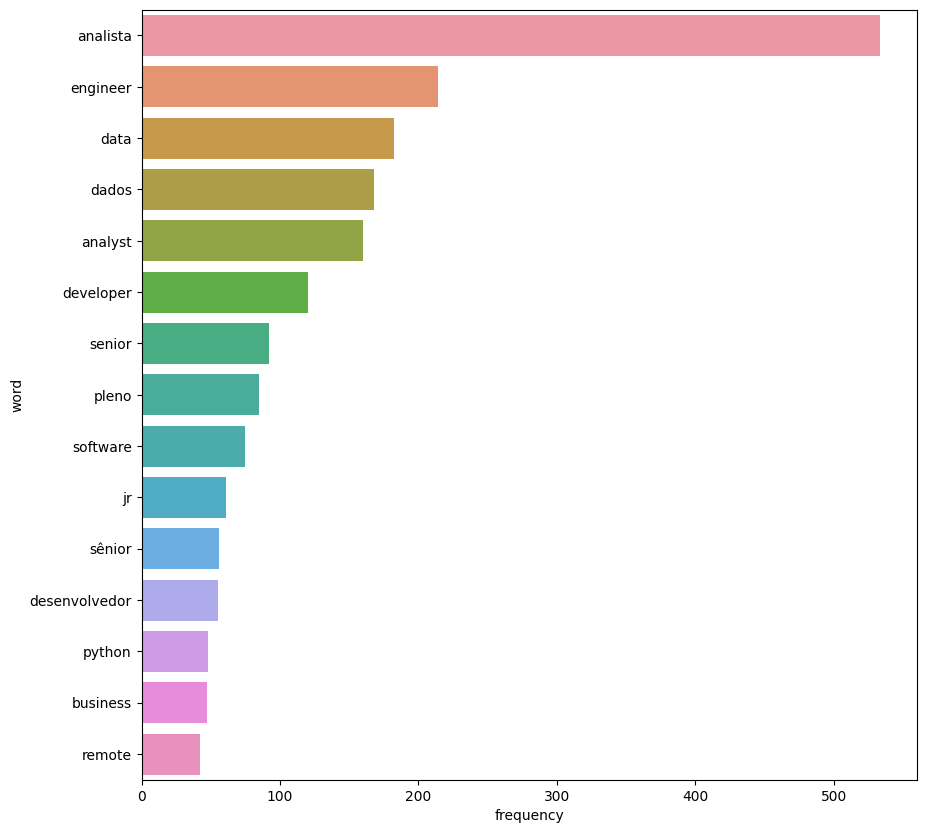

In [230]:
all_positions = ' '.join(df_jobs['position']).lower().replace(' de ', ' ').replace('-', ' ').replace('|', ' ').replace(' e ', ' ').replace(' em ', ' ').replace(' from ', '').replace(' & ', ' ')
words_list = all_positions.split()
counted_words = Counter(words_list)
df_position_words = pd.DataFrame.from_dict(counted_words, orient='index', columns=['frequency'])
df_position_words.index.name = 'word'
df_position_words = df_position_words.reset_index().sort_values(by='frequency', ascending=False)
plt.subplots(figsize=(10,10))
sns.barplot(data=df_position_words.head(15), y='word', x='frequency')

## Counting main columns

In [231]:
def generate_count(dataframe, to_group_column, to_count_column):
    return dataframe.groupby(to_group_column)[to_count_column].count().reset_index().sort_values(ascending=False, by=to_count_column)

counted_columns = dict()
for col in ['posted_date', 'no_applicants', 'type_workplace', 'level', 'worktype',
       'company_name', 'company_size', 'company_sector', 'city', 'state',
       'country', 'link_application_simplified']:
    counted_columns[col] = generate_count(df_jobs, col, ['position'])

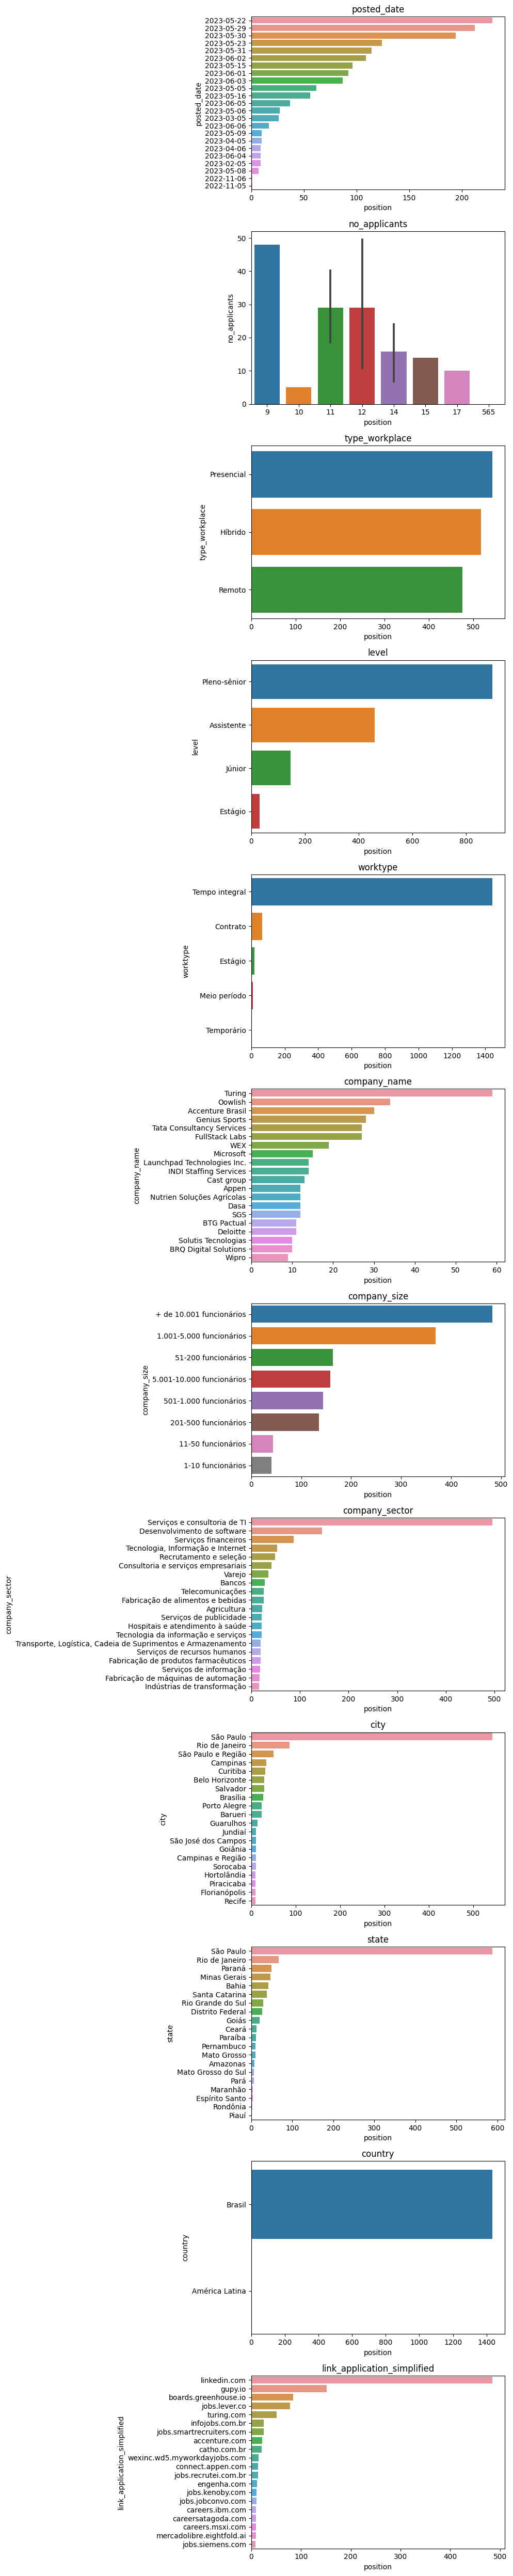

In [232]:
fig, ax = plt.subplots(len(counted_columns), 1, figsize=(10, 50))
for i, key in enumerate(counted_columns.keys()):
    if len(counted_columns[key]) > 20:
        sns.barplot(data=counted_columns[key].head(20), y=key, x='position', ax=ax[i])
    else:
        sns.barplot(data=counted_columns[key], y=key, x='position', ax=ax[i])
    ax[i].set_title(key)
sns.barplot(data=counted_columns['posted_date'], y=counted_columns['posted_date']['posted_date'].dt.strftime('%Y-%m-%d'), x='position', ax=ax[0])
fig.tight_layout()

<Axes: xlabel='position', ylabel='type_workplace'>

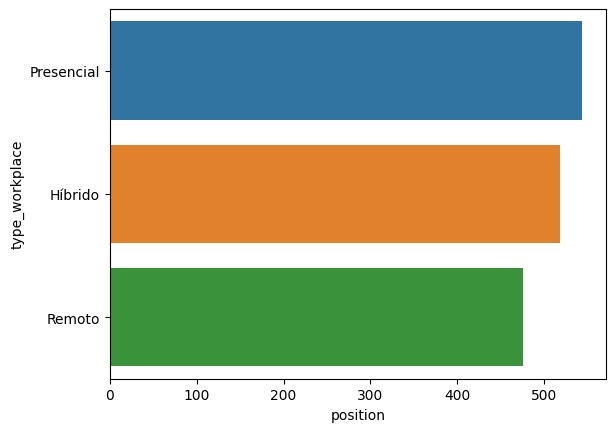

In [233]:
key = 'type_workplace'
sns.barplot(data=counted_columns[key], y=key, x='position')

<Axes: xlabel='position', ylabel='level'>

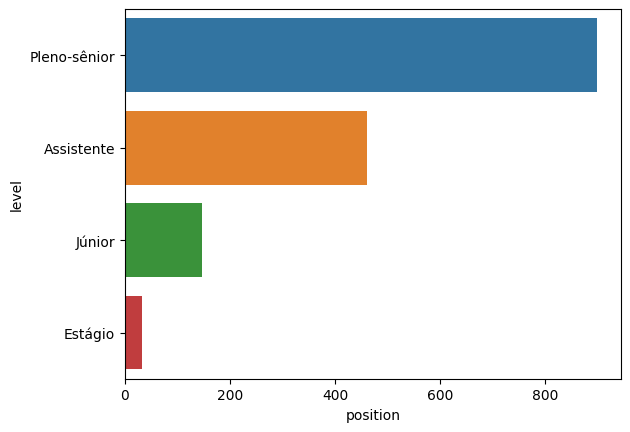

In [234]:
key = 'level'
sns.barplot(data=counted_columns[key], y=key, x='position')

<Axes: xlabel='position', ylabel='worktype'>

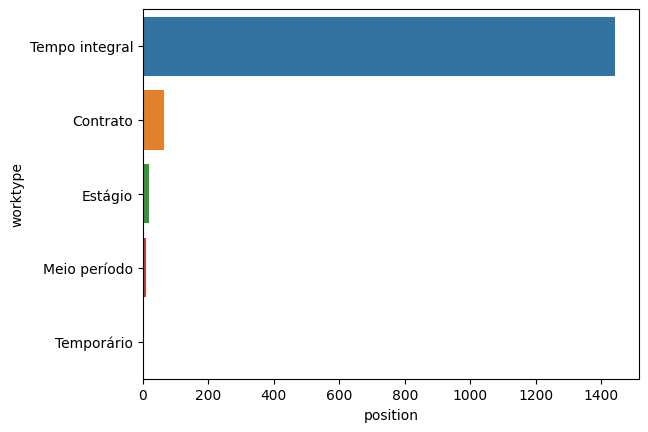

In [235]:
key = 'worktype'
sns.barplot(data=counted_columns[key], y=key, x='position')

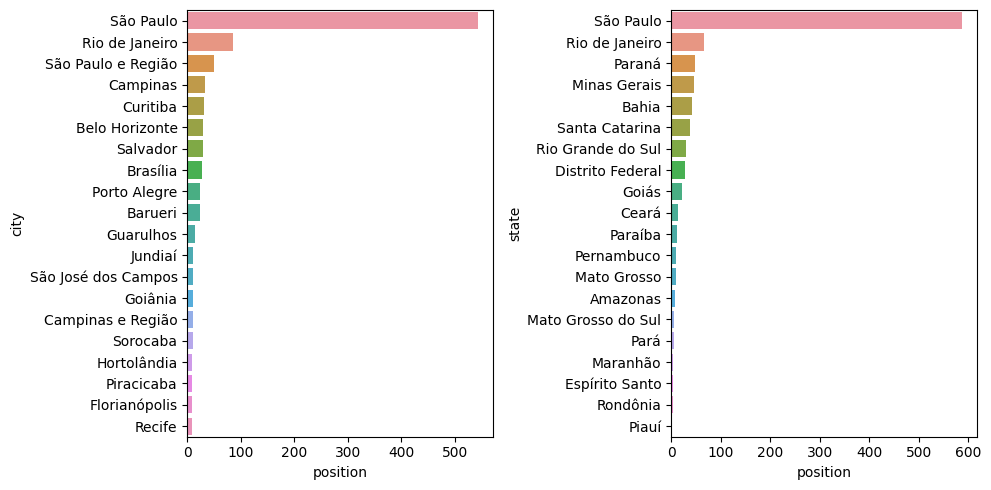

In [236]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
key = 'city'
sns.barplot(data=counted_columns[key].head(20), y=key, x='position', ax=ax[0])
key = 'state'
sns.barplot(data=counted_columns[key].head(20), y=key, x='position', ax=ax[1])
plt.tight_layout()

<Axes: xlabel='position', ylabel='company_sector'>

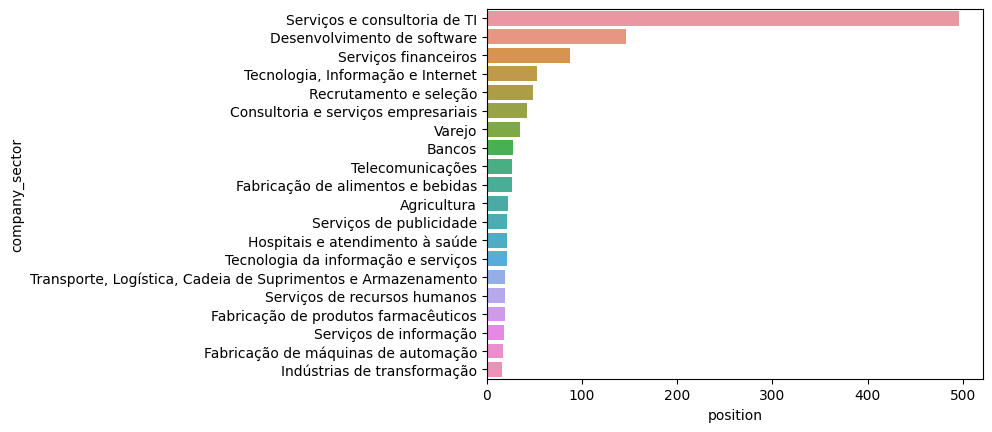

In [237]:
key = 'company_sector'
sns.barplot(data=counted_columns[key].head(20), y=key, x='position')

## Counting skills

In [238]:
counted_skills.shape

(2656, 3)

<Axes: xlabel='count', ylabel='required_skills'>

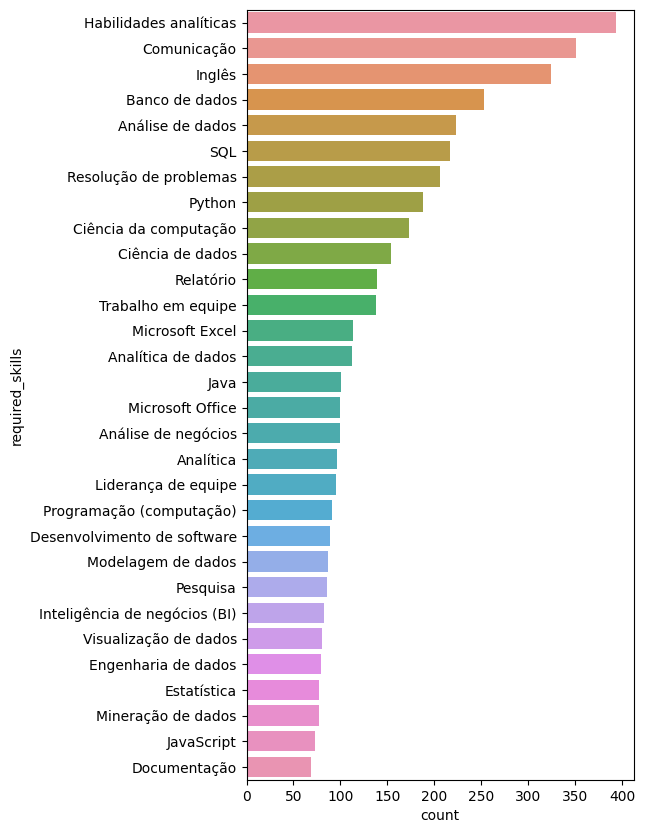

In [239]:
counted_skills = generate_count(df_exploded_skills, 'required_skills', 'index').rename({'index': 'count'}, axis=1)
counted_skills['percentage_count'] = counted_skills['count'] / counted_skills['count'].sum()
plt.subplots(figsize=(5, 10))
sns.barplot(data=counted_skills.head(30), y='required_skills', x='count')

## Top-30 most required skills by Type of Worplace

In [240]:
df_jobs_merged = pd.merge(df_jobs, pd.get_dummies(df_exploded_skills).reset_index().groupby('index').sum(), how='inner', left_index=True, right_on='index').reset_index()

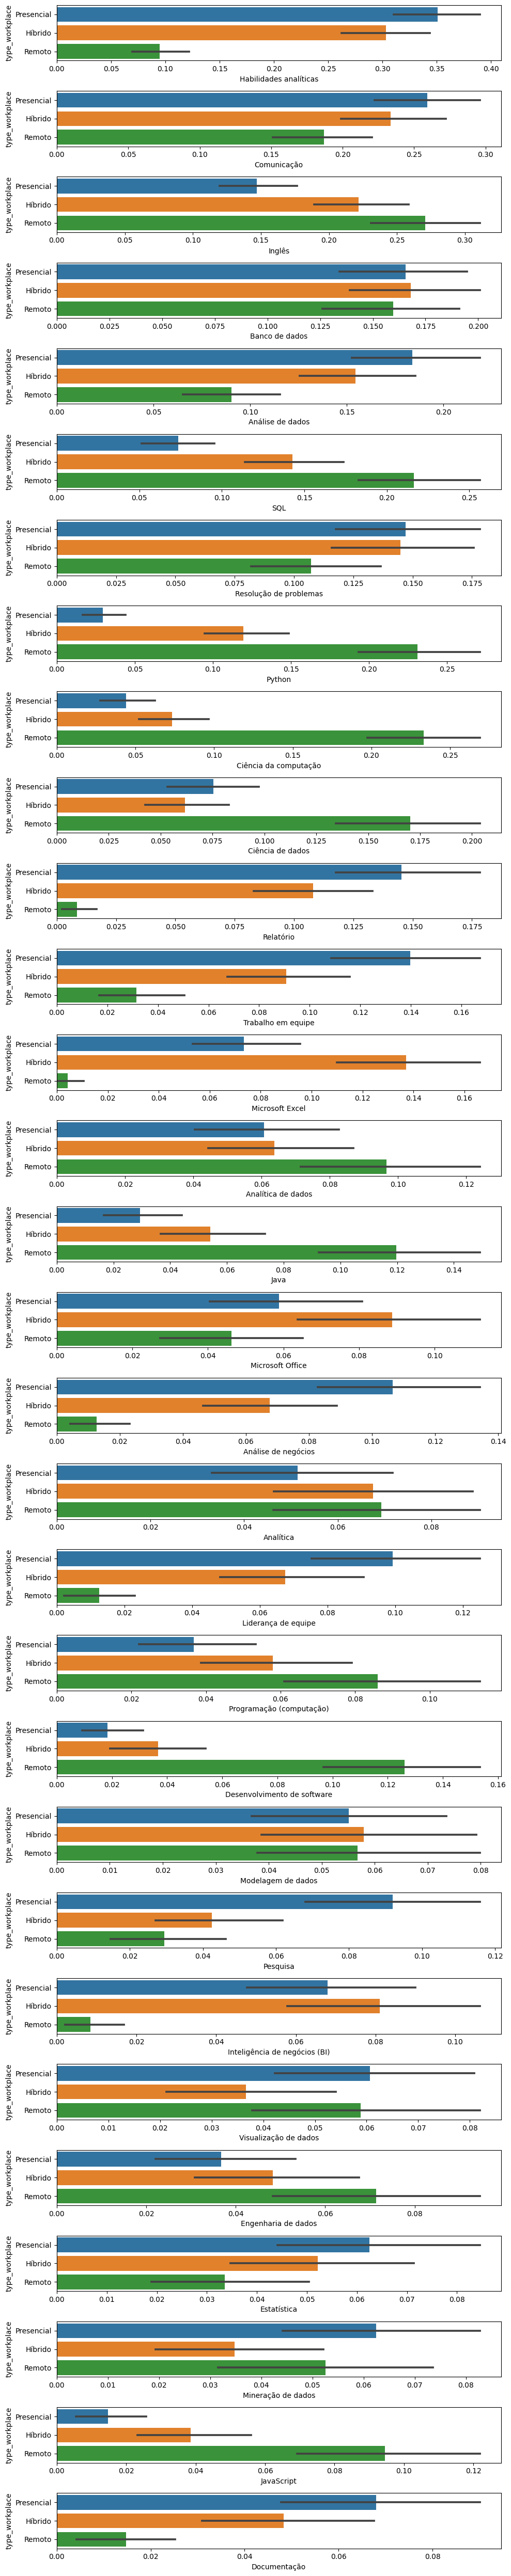

In [241]:
fig, ax = plt.subplots(30, 1, figsize=(10, 50))
for i, skill in enumerate(counted_skills.required_skills.head(30)):
    key = f'required_skills_{skill}'
    sns.barplot(data=df_jobs_merged, x=key, y='type_workplace', ax=ax[i])
    ax[i].set_xlabel(skill)

plt.tight_layout()

## Top-30 most required skills by Level of the Position

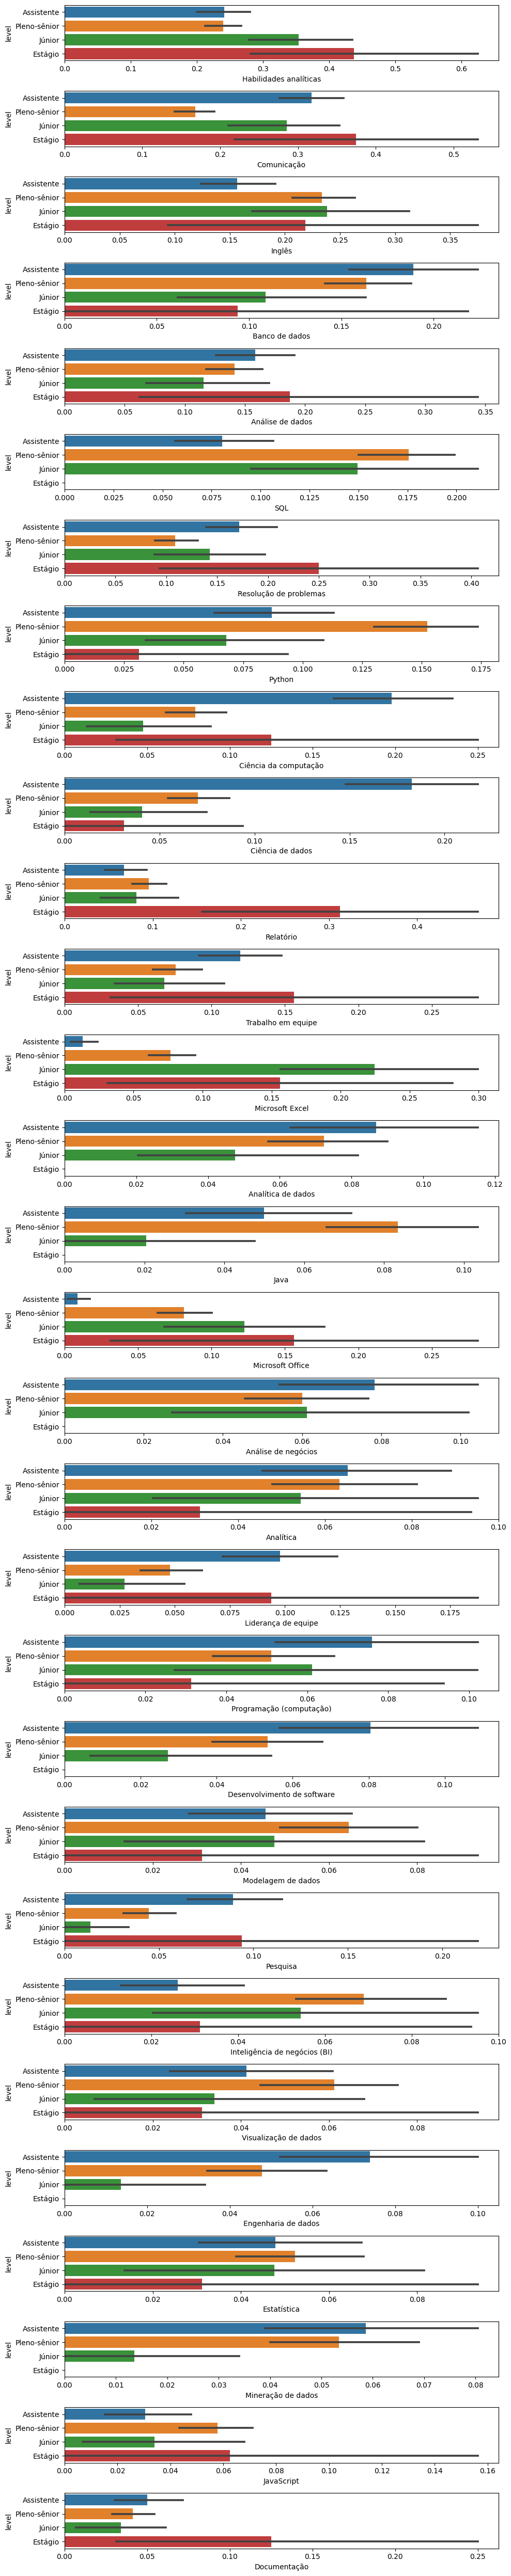

In [242]:
fig, ax = plt.subplots(30, 1, figsize=(10, 50))
for i, skill in enumerate(counted_skills.required_skills.head(30)):
    key = f'required_skills_{skill}'
    sns.barplot(data=df_jobs_merged, x=key, y='level', ax=ax[i])
    ax[i].set_xlabel(skill)

plt.tight_layout()

## Classified Skills (by ChatGPT)

In [162]:
def classify_skills(skill):
    classified_skills = {'Habilidades analíticas': ['Análise de dados', 'Análise de negócios', 'Analítica de dados', 'Analítica', 'Modelagem de dados', 'Mineração de dados', 'Inteligência de negócios (BI)', 'Inteligência artificial', 'Análise estatística', 'Análise de dados estatísticos', 'Análise financeira', 'Análise estatística', 'Análise de produtos', 'Análise de problemas', 'Análise técnica', 'Pesquisa qualitativa', 'Pesquisa de mercado', 'Análise de marketing', 'Análise de riscos', 'Análise de séries temporais', 'Geração de insights', 'Resolução de problemas', 'Ciência da computação', 'Ciência de dados', 'Visualização de dados', 'Engenharia de dados', 'Estatística', 'Benefícios de funcionários', 'Indicadores-chave de desempenho', 'Economia', 'Padrões de design', 'Programação orientada a objetos (POO)', 'Negociação', 'Gestão de projetos', 'Finanças', 'Melhoria de processos', 'Manipulação de dados', 'Capacidade analítica', 'Análise de sistemas', 'Otimização', 'Desenvolvimento de relatório', 'Big data', 'Programação de linguagem de consulta', 'Gestão de dados', 'Planejamento', 'Administração', 'Competências interpessoais', 'Tomada de decisão', 'Capacidade de organização', 'Engenharia', 'Litígios', 'Planos de ação', 'Modelos de dados', 'Governança de dados', 'Estudos de casos', 'Processos empresariais', 'Orçamento', 'DAX (Expressões de análise de dados)', 'ITIL', 'Integração contínua', 'Snowflake', 'ERP (Planejamento de recursos empresariais)', 'Desenvolvimento de front-end', 'Processamento de dados', 'Planejamento de testes', 'Implementação de projetos', 'Ciclo de vida de sistemas de informação', 'Teste de unidade', 'Revisão de código', 'Arquitetura de dados', 'Qualidade dos dados', 'Scrum', 'Satisfação do cliente', 'Design de software', 'Documentação técnica', 'Inteligência de mercado', 'Aprendizagem profunda', 'Operações', 'Compras', 'Planejamento estratégico', 'Selenium', 'Controle interno', 'NumPy', 'Arquitetura técnica', 'Modelagem estatística', 'Processamento de imagem', 'Engenharia de Computação', 'Liderança', 'Hive', 'Melhoria contínua', 'Cucumber', 'Gestão de produtos', 'Resposta a incidentes', 'Ruby on Rails', 'Desenvolvimento de soluções', 'Impostos', 'Histórias de usuários', 'Analítica preditiva', 'MRP (Planejamento das necessidades de materiais)', 'Engajamento de clientes', 'Arquitetura de soluções', 'ServiceNow', 'Algoritmos', 'Procedimentos armazenados', 'Setor público', 'Solução de problemas técnicos', 'Pesquisa', 'Aprendizado de máquina', 'Matemática', 'Pensamento crítico', 'Requisitos de negócio', 'Estruturas de dados', 'Reconhecimento de padrões', 'Data warehouse', 'Levantamento de requisitos', 'Garantia de qualidade', 'Controle de qualidade', 'Contabilidade', 'Análise de causa raiz (RCA)', 'Datasets', 'Contabilidade estatuária', 'Limpeza de dados', 'Análise de requisitos', 'Teste A/B', 'Root Cause', 'Teste de aceitação de usuários', 'Execução de testes', 'Privacidade dos dados', 'Relatórios empresarias', 'Controle de inventário', 'Estoque', 'Demonstrações financeiras', 'Detecção de objetos', 'Sistema ERP (SIGE)', 'SGBD', 'Pipeline de dados', 'Preparação de dados', 'Capacidade de adaptação', 'Planejamento de demanda', 'Contas a pagar', 'Testes funcionais', 'Teste de regressão', 'Teste de integração', 'Automação de testes', 'Validação de dados'], 'Comunicação': ['Comunicação', 'Comunicação interpessoal', 'Comunicação oral', 'Comunicação escrita', 'Articulação (TI)', 'Argumentation', 'Coordenação de projetos', 'Condução de reuniões', 'Anotações', 'Oratória', 'Demonstração de produtos', 'Relações públicas', 'Inglês', 'Relatório', 'Trabalho em equipe', 'Apresentações', 'Documentação', 'Instrução', 'Benefícios de funcionários', 'Vendas', 'Marketing', 'Criação de relacionamentos', 'Insights de negócios', 'Relacionamentos interpessoais', 'Promoção da inclusão', 'Satisfação do cliente', 'Resposta a incidentes', 'Recursos humanos (RH)', 'Propaganda comercial', 'Comunicação social', 'Treinamento', 'Coaching', 'Gestão de incidentes', 'Experiência do usuário (UX)', 'Web Design Responsivo', 'Relacionamento com clientes', 'Satisfação do cliente', 'Engajamento de clientes', 'Experiência do cliente', 'Relacionamento como cliente', 'Gestão de contas', 'Vendas', 'Atendimento ao cliente', 'Sucesso do cliente', 'CRM', 'Marketing', 'Marketing digital', 'SEO', 'Publicidade', 'E-mail marketing', 'Marketing de conteúdo', 'Marketing de mídia social', 'Marketing de busca', 'Marketing de marca', 'Marketing estratégico', 'Gestão de projetos', 'Planejamento de projetos', 'Gestão de projetos ágeis', 'Gestão de equipes de projeto', 'Gerenciamento de riscos', 'Gerenciamento de tempo', 'Gerenciamento de recursos', 'Gerenciamento de custos', 'Design thinking', 'UI/UX Design', 'Design de interface do usuário', 'Design de experiência do usuário', 'Design de experiência do cliente', 'Design de marca'], 'Linguagens de programação': ['SQL', 'Python', 'Java', 'JavaScript', 'C#', 'HTML', 'CSS', 'TypeScript', 'Scala', 'C (linguagem de programação)', 'C++', 'Ruby', 'Swift (Linguagem de programação)', 'Go (Linguagem de programação)', 'PL/SQL', 'R (linguagem de programação)', 'ABAP', 'Shell script', 'JQuery', 'VBA (Visual Basic for Applications)', 'Linguagens de programação', 'React.js', 'PySpark', '.NET Framework', 'XML', 'Angular (Framework)', 'Android', 'JSON', 'PHP', 'Ruby on Rails', 'Kotlin', 'Desenvolvimento de back-end', 'Desenvolvimento de sistemas', 'Desenvolvimento de aplicativos móveis', 'Desenvolvimento orientado ao comportamento', 'Desenvolvimento de soluções', 'Desenvolvimento de front-end', 'API REST', 'Technical Specs', 'Planilhas Google', '.NET Core', 'Spring Boot', 'Spring Data', 'Desenvolvimento Android', 'WordPress'], 'Tecnologias e ferramentas': ['Banco de dados', 'Microsoft Excel', 'Microsoft Office', 'Microsoft PowerPoint', 'Programação (computação)', 'Desenvolvimento de software', 'Produtos SAP', 'ETL (Extração, transformação e carregamento)', 'Dashboards', 'MySQL', 'NoSQL', 'Linux', 'Amazon Web Services', 'Processamento de linguagem natural (PLN)', 'Kubernetes', 'Django', 'Windows Azure', 'Git', 'Metodologias Agile', 'Google Cloud Platform (GCP)', 'DevOps', 'Microsoft SQL Server', 'Docker', 'Microsoft Power BI', 'Banco de dados Oracle', 'MongoDB', 'Tableau', 'Apache Spark', 'Apache Kafka', 'PostgreSQL', 'Spring Framework', 'Amazon RDS', 'Looker (Software)', 'SAS', 'Firewalls', 'GoldMine (CRM)', 'Salesforce.com', 'GitLab', 'Ansible', 'Redis', 'Azure Data Factory', 'Terraform', 'Dynatrace', 'Azure Databricks', 'Azure DevOps', 'OpenCV', 'Microsoft Visual Studio', 'Jupyter Notebook', 'Elasticsearch', 'Kibana', 'Grafana', 'Prometheus', 'Hadoop', 'Hive (software)', 'Impala (software)', 'Presto (software)', 'Airflow (software)', 'Keras', 'PyTorch', 'TensorFlow', 'Node.js', 'Computação em nuvem', 'Internet Access', 'Skype', 'YouTube', 'Snowflake', 'Google Analytics', 'Office 365', 'JIRA', 'Microsoft Windows', 'iOS', 'Controle de versão', 'Segurança da informação', 'Teste de software', 'Selenium', 'ServiceNow', 'Automação', 'Suporte técnico', 'Interface de programação de aplicativos (API)', 'Sistemas operacionais', 'Segurança da informação', 'Teste de software', 'Comércio eletrônico', 'Implementação SAP', 'Auditoria', 'SDLC (Ciclo de vida do desenvolvimento de software)', 'Pipeline de dados', 'Container Orchestration', 'Bancos de dados relacionais', 'SQL Server Analysis Services (SSAS)', 'Active Directory', 'Implantação de software', 'Visualização', 'Fontes tipográficas', 'Airflow', 'Contas a receber', 'Administração de sistemas', 'Administração de sistemas Linux', 'Servidor Windows', 'Integração', 'Arquitetura', 'Arquitetura de software', 'Análise financeira', 'Gestão financeira', 'Contabilidade', 'Orçamento', 'Planejamento financeiro', 'Modelagem financeira', 'Análise de investimentos', 'Gestão de tesouraria', 'Auditoria interna', 'Análise de risco financeiro', 'Controle financeiro', 'Gestão de ativos', 'Relatórios financeiros', 'Finanças corporativas', 'M&A', 'Fundos de investimento', 'Design gráfico', 'Design de interiores', 'Desenvolvimento web', 'Desenvolvimento de aplicativos móveis', 'Desenvolvimento de jogos', 'Desenvolvimento de software', 'Ferramentas de produtividade', 'Ferramentas de análise de dados', 'Ferramentas de visualização de dados', 'Plataformas de nuvem', 'Redes de computadores', 'Administração de redes', 'Armazenamento de dados', 'Big Data', 'Ciência de dados', 'Aprendizado de máquina', 'Inteligência artificial', 'Deep Learning', 'Processamento de linguagem natural (PLN)', 'Visão computacional', 'Ferramentas de modelagem', 'Ferramentas de simulação', 'Ferramentas de colaboração', 'Ferramentas de gerenciamento de projetos', 'Ferramentas de controle de versão', 'Ferramentas de automação de processos', 'Automação de marketing', 'Automação de vendas', 'Automação de atendimento ao cliente', 'Chatbots', 'Robótica', 'IoT']}
    for key in classified_skills:
        if skill in classified_skills[key]:
            return key
counted_skills['category'] = counted_skills.required_skills.map(classify_skills)

<Axes: xlabel='percentage_count', ylabel='category'>

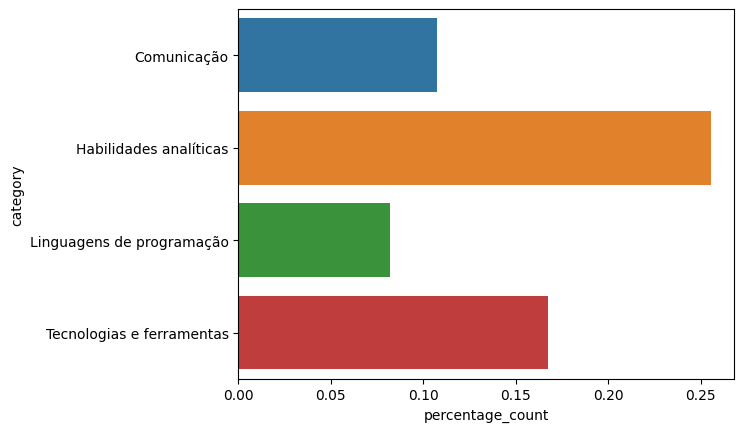

In [163]:
sum_categories = counted_skills.groupby('category')[['count', 'percentage_count']].sum().reset_index()
sns.barplot(data=sum_categories, x='percentage_count', y='category')

<Axes: xlabel='percentage_count', ylabel='required_skills'>

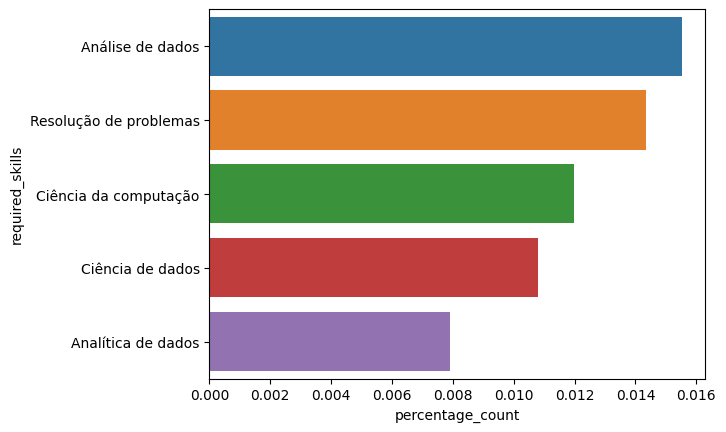

In [167]:
sns.barplot(counted_skills[counted_skills['category']=='Habilidades analíticas'].head(5), y='required_skills', x='percentage_count')

<Axes: xlabel='percentage_count', ylabel='required_skills'>

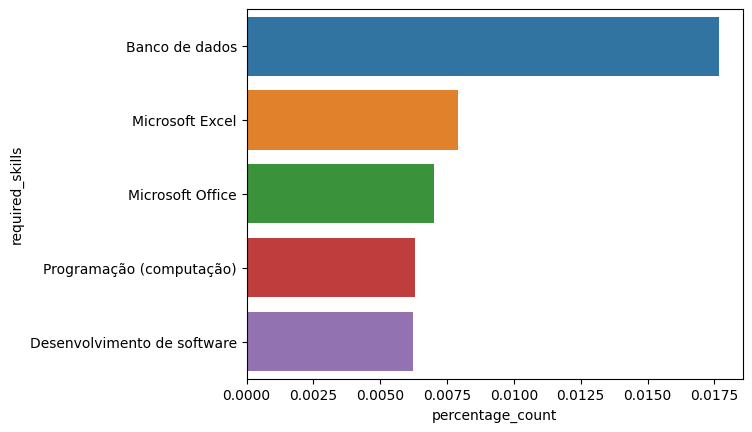

In [169]:
sns.barplot(counted_skills[counted_skills['category']=='Tecnologias e ferramentas'].head(5), y='required_skills', x='percentage_count')

<Axes: xlabel='percentage_count', ylabel='required_skills'>

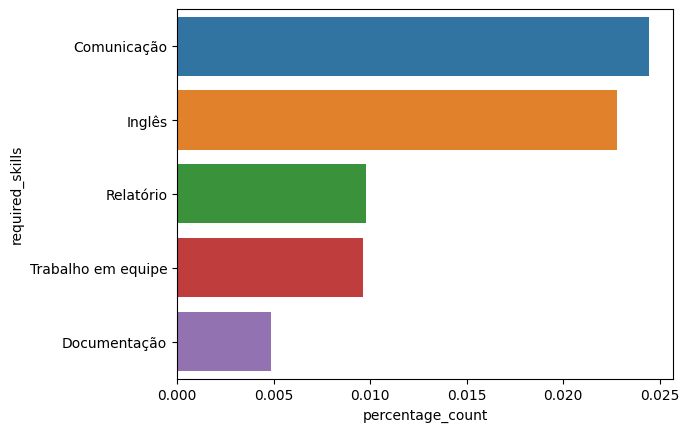

In [170]:
sns.barplot(counted_skills[counted_skills['category']=='Comunicação'].head(5), y='required_skills', x='percentage_count')

<Axes: xlabel='percentage_count', ylabel='required_skills'>

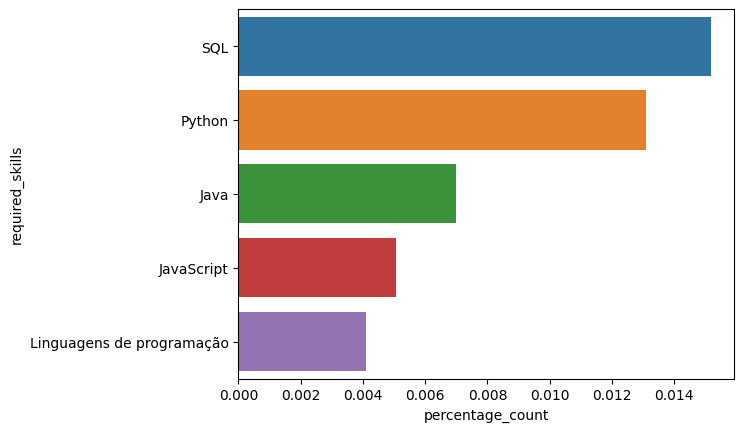

In [171]:
sns.barplot(counted_skills[counted_skills['category']=='Linguagens de programação'].head(5), y='required_skills', x='percentage_count')